# Imports and Data Loading

In [1]:
%reload_ext autoreload
%matplotlib widget 
import h5py
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import os 
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [12]:
# Load data and display the sessions 
animal="FN" # "FN" or "WI" 
data_file = "path/to/data.h5"
assert os.path.exists(data_file), "File not found: {data_file}".format(data_file=data_file)

with h5py.File(data_file, 'r') as f:
    sessions = list(f.keys())

<KeysViewHDF5 ['10-14-2022', '10-15-2022', '10-16-2022', '10-18-2022', '10-19-2022', '10-20-2022', '10-21-2022', '10-22-2022', '10-23-2022', '10-24-2022', '10-25-2022', '10-27-2022', '10-28-2022', '10-29-2022', '10-30-2022', '10-31-2022', '11-01-2022']>


In [4]:
# Load data for a particular session and view the format of the data
session = sessions[0]
# convert mm-dd-yyyy to mm/dd/yyyy
date_str = session.replace('-', '/')

with h5py.File(data_file, 'r') as f:
    print(f[sessions[i]].keys())
    epoc_np=np.array(f[sessions[i]]['epoch'])
    rem_rec_np=np.array(f[sessions[i]]['rem_rec'])
    trial_np=np.array(f[sessions[i]]['trial'])
    binned_spike_np = np.array(f[sessions[i]]['binned_spike'])
    meta = np.array(f[sessions[i]]['meta'])

rem_rec_bin = np.array([1 if x == b'Remote' else 0 for x in rem_rec_np])

block_num = 0
block_nums = np.zeros(len(rem_rec_bin), dtype=int)  # Initialize array with zeros

for i in range(1, len(rem_rec_bin)):
    if rem_rec_bin[i] != rem_rec_bin[i-1]:  # If trial type changes
        block_num += 1  # Increment block number
    block_nums[i] = block_num  # Assign block number to current trial

unique_blocks = np.unique(block_nums)

<KeysViewHDF5 ['binned_spike', 'epoch', 'meta', 'rem_rec', 'trial']>


In [5]:
# Get correct and incorrect trials per screen 

df = pd.read_csv("Y:/LAMBDA/Sub-Project/SLUR(..)/data/FN/FN_TT_ALL_refined.csv")
df = df[df['Date'] == date_str]
print(df.head())

screen_correct = np.zeros((4, df['TrialNum'].max()))
screen_correct[0, :] = df["Correct"][::4]
screen_correct[1, :] = df["Correct"][1::4]
screen_correct[2, :] = df["Correct"][2::4]
screen_correct[3, :] = df["Correct"][3::4]
screen_correct_drift = screen_correct[:, :-1]

       TrialNum        Date  Domain  Correct  Screen  SQelement  \
10700         1  10/15/2022  Recent        1       6          1   
10701         1  10/15/2022  Recent        1       5          2   
10702         1  10/15/2022  Recent        1       1          3   
10703         1  10/15/2022  Recent        1       2          4   
10704         2  10/15/2022  Recent        1       6          1   

       NumDistractor  CueContexSet TouchedStimPos  TouchedStimID  RESP  
10700              3  ProDet-Set42      [[-7 10]]            106   104  
10701              3  ProDet-Set42    [[ -7 -10]]            105   104  
10702              3  ProDet-Set42      [[ 7 10]]            101   104  
10703              3  ProDet-Set42      [[-7 10]]            102   104  
10704              3  ProDet-Set42      [[-7 10]]            106   104  


In [7]:
# Only keep rows where in at least one bin, the neuron fired at least 500 times 
# (i.e. the neuron is not active in that bin)

rows_to_keep = [] 
for i in unique_blocks:
    for j in range(binned_spike_np.shape[0]):
        if np.sum(binned_spike_np[j, block_nums == i]) >= 500:
            rows_to_keep.append(j)

rows_to_keep = np.unique(rows_to_keep)

binned_spike_np = binned_spike_np[rows_to_keep, :]

# Normalize binned spike data 
binned_spike_np_z = scipy.stats.zscore(binned_spike_np, axis=1)

# Decoding

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Simple logistic regression classifier to predict behavior (classification) from low dimensional data (data)

def logistic_regression_classifier(data, classification):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)

    # Fit the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


# PCA

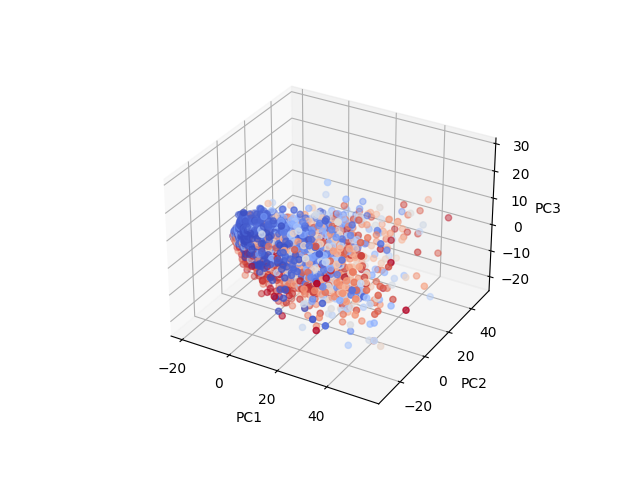

array([[ -9.55473264,  -7.65282108,  -4.13642442],
       [-10.4710204 ,  -5.01678402,  -1.05315586],
       [ -8.43431185,  -7.64916387,   0.68815902],
       ...,
       [  3.18183125,   1.29698811,  -4.03726158],
       [ -2.46065907,   5.55739501,  -6.90947966],
       [ -0.07566019,   0.2915592 ,   0.08740178]])

In [11]:
# PCA on all labels

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def PCA_binned_spike_np(X, y):
    pca = PCA(n_components=3)
    pca.fit(np.transpose(X))
    embedding = pca.transform(np.transpose(X))

    # Plot PCA embedding and color by value in epoc_np
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y, cmap = 'coolwarm')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()
    return embedding

PCA_binned_spike_np(binned_spike_np, trial_np)

# t-SNE

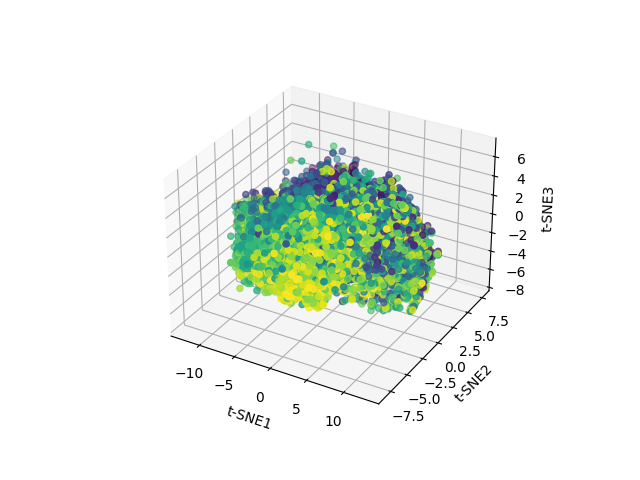

array([[-9.442278  ,  6.329906  , -1.4598128 ],
       [-9.3287115 ,  5.8955846 , -1.2188224 ],
       [-9.024981  ,  6.4292135 , -1.3417357 ],
       ...,
       [ 4.4483976 , -4.282513  , -0.17728671],
       [ 1.9140247 , -5.249714  ,  1.9297034 ],
       [ 0.57354355,  1.6661214 ,  1.0400898 ]], dtype=float32)

In [14]:
from sklearn.manifold import TSNE

def TSNE_binned_spike_np(X, y):
    # t-SNE
    tsne = TSNE(n_components = 3, perplexity=100)
    embedding = tsne.fit_transform(np.transpose(X))

    # Plot the first three components in 3d and make the plot interactive
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter_plot = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = y)
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    ax.set_zlabel('t-SNE3')
    plt.show()

    return embedding

TSNE_binned_spike_np(binned_spike_np, trial_np)

In [ ]:
# Use optuna (bayesian optimization) to find the best hyperparameters for t-SNE to maximize classification accuracy

import optuna
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = binned_spike_np # neural data
y = rem_rec_np # classification labels

# Simple logistic regression classifier to predict behavior (classification) from low dimensional data (data)
def logistic_regression_classifier(data, classification):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)

    # Fit the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the objective function for Optuna
def objective(trial):
    # Define the t-SNE object with the hyperparameters to optimize
    tsne = TSNE(
        n_components=3,
        perplexity=trial.suggest_int('perplexity', 5, len(y)-1),
        learning_rate=trial.suggest_float('learning_rate', 10, 100),
        n_iter=trial.suggest_int('n_iter', 250, 1000),
        random_state=42
    )

    # Transform the data with t-SNE
    tsne_embedding = tsne.fit_transform(np.transpose(X))
    accuracy = logistic_regression_classifier(tsne_embedding, y)
    return accuracy

# Define the study object for Optuna
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters with Optuna
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

# Plot the t-SNE embedding with the best hyperparameters
tsne = TSNE(
    n_components=3,
    perplexity=study.best_params['perplexity'],
    learning_rate=study.best_params['learning_rate'],
    n_iter=study.best_params['n_iter'],
    random_state=42
)
tsne_embedding = tsne.fit_transform(np.transpose(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_embedding[:,0], tsne_embedding[:,1], tsne_embedding[:,2], c=y, cmap='jet')
ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')
ax.set_zlabel('t-SNE3')
ax.set_title('t-SNE on Block Segment (Firing Rate)')

clf = LogisticRegression(random_state=0)
score = cross_val_score(clf, tsne_embedding, y, cv=5).mean()
print("Classification accuracy for remote/recent:", score)

# UMAP

c:\Users\Perpl\anaconda3\envs\manifolds\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


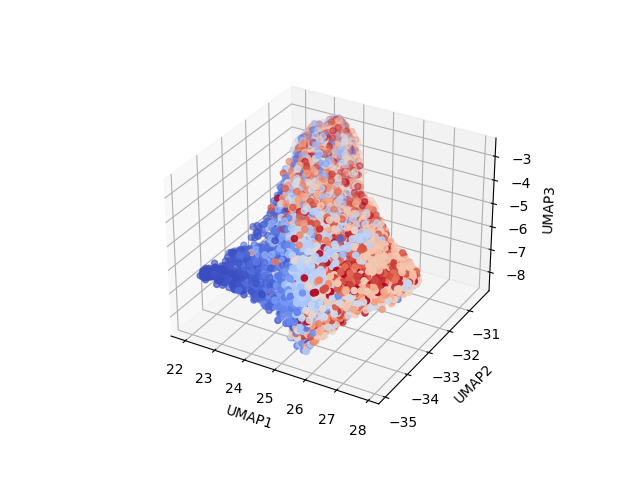

array([[ 21.97491  , -34.464657 ,  -6.637969 ],
       [ 22.10199  , -34.422024 ,  -6.5384197],
       [ 21.997677 , -34.370304 ,  -6.503773 ],
       ...,
       [ 26.347157 , -34.081673 ,  -5.331875 ],
       [ 26.871296 , -32.924713 ,  -5.046649 ],
       [ 24.586287 , -33.07979  ,  -5.4912868]], dtype=float32)

In [17]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.preprocessing import StandardScaler

def UMAP_neural(X = binned_spike_np, y = trial_np, params = {'n_dims':3, 'metric': 'euclidean', 'n_neighbors':200, 'min_dist':0.2, 'init': 'spectral'}): 
    reducer = umap.UMAP(n_components=3, n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], metric=params['metric'], init='spectral', random_state=42)
    scaled_block_firing_rate = StandardScaler().fit_transform(np.transpose(X))
    embedding = reducer.fit_transform(scaled_block_firing_rate)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter_plot = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = y, cmap='coolwarm')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    #fig.colorbar(scatter_plot, ax=ax)
    plt.show()
    return embedding

UMAP_neural()

[I 2023-11-19 18:36:05,150] A new study created in memory with name: no-name-0a149996-4862-443d-afa1-73c8a95659f3
[I 2023-11-19 18:36:09,069] Trial 0 finished with value: 0.41025641025641024 and parameters: {'n_neighbors': 556, 'min_dist': 0.33549778900781574, 'spread': 1.0443732328412385, 'metric': 'cosine'}. Best is trial 0 with value: 0.41025641025641024.
[I 2023-11-19 18:36:12,572] Trial 1 finished with value: 0.41025641025641024 and parameters: {'n_neighbors': 416, 'min_dist': 0.6389105655862005, 'spread': 1.379470236900258, 'metric': 'cosine'}. Best is trial 0 with value: 0.41025641025641024.
[I 2023-11-19 18:36:16,123] Trial 2 finished with value: 0.358974358974359 and parameters: {'n_neighbors': 596, 'min_dist': 0.14289697084365496, 'spread': 1.149926504571351, 'metric': 'euclidean'}. Best is trial 0 with value: 0.41025641025641024.
[I 2023-11-19 18:36:19,789] Trial 3 finished with value: 0.38461538461538464 and parameters: {'n_neighbors': 214, 'min_dist': 0.6961262665478583, '

Best parameters:  {'n_neighbors': 281, 'min_dist': 0.7509383849785293, 'spread': 1.2561941110636126, 'metric': 'cosine'}
Best score:  0.5128205128205128
Classification accuracy for remote/recent: 0.6331092888829144


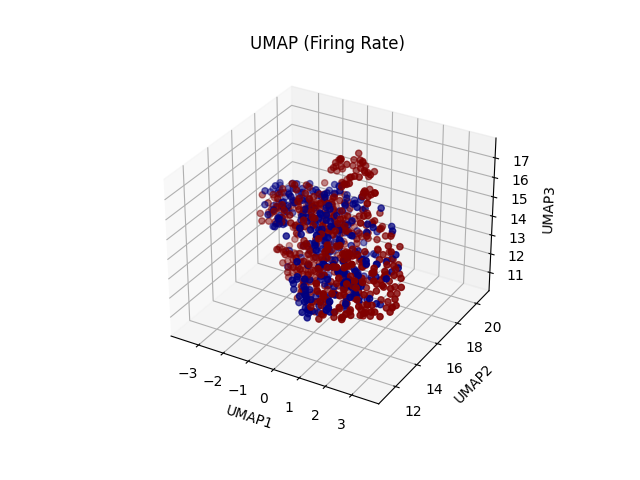

In [33]:
# Use optuna (bayesian optimization) to find the best hyperparameters for UMAP to maximize classification accuracy 

import optuna
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X = binned_spike_np
y = rem_rec_np

def logistic_regression_classifier(data, classification):
    X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


def objective(trial):
    umap = UMAP(
        n_components=3,
        n_neighbors=trial.suggest_int('n_neighbors', 100, len(y)-1),
        min_dist=trial.suggest_float('min_dist', 0.01, 1),
        spread=trial.suggest_float('spread', 1.0, 1.5),
        metric=trial.suggest_categorical('metric', ['cosine', 'euclidean']), 
    )
    umap_embedding = umap.fit_transform(np.transpose(X))
    #accuracy = logistic_regression_classifier(umap_embedding, y)
    accuracy = logistic_regression_classifier(umap_embedding)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

umap = UMAP(
    n_components=3,
    n_neighbors=study.best_params['n_neighbors'],
    min_dist=study.best_params['min_dist'],
    spread=study.best_params['spread']
)
umap_embedding = umap.fit_transform(np.transpose(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], umap_embedding[:,2], c=y, cmap='jet')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.set_title('UMAP (Firing Rate)')

clf = LogisticRegression(random_state=0)
score = cross_val_score(clf, umap_embedding, y, cv=5).mean()
print("Classification accuracy for remote/recent:", score)